## Cloudless Mosiac

This tutorial constructs a *cloudless mosiac* (also known as a composite) from a time series of satellite images. We'll see how to

* Find a time series of images at a particular point on Earth
* Stack those images together into a single array
* Compute the cloud-free mosiac by taking a median
* Visualize the results

This example uses [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data. The techniques used here apply equally well to other remote-sensing datasets.

In [1]:
import numpy as np
import xarray as xr
import rioxarray

import rasterio
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

from dask_gateway import GatewayCluster

### Create a Dask Cluster

We're going to process a large amount of data. To cut down on the execution time, we'll use a Dask cluster to do the computation in parallel, adaptively scaling to add and remove workers as needed. See [Scale With Dask](../quickstarts/scale-with-dask.ipynb) for more on using Dask.

In [2]:
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

https://pcc-staging.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/staging.870067ada7684ea48beb5cdd160ce7d8/status


### Discover Data

In this example, we define our area of interest as a GeoJSON object. It's near Redmond, Washington.

In [3]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.27508544921875, 47.54687159892238],
            [-121.96128845214844, 47.54687159892238],
            [-121.96128845214844, 47.745787772920934],
            [-122.27508544921875, 47.745787772920934],
            [-122.27508544921875, 47.54687159892238]
        ]
    ],
}
bbox = rasterio.features.bounds(area_of_interest)

Using `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

In [4]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bbox,
    datetime="2016-01-01/2020-12-31",
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
)

print(search.matched())

514


So 514 items matched our search. The STAC items returned by that search include a property `eo:cloud_cover` that indicates cloud cover as a percentage (0 – 100) of the entire scene. We'll keep just the items that are less that 25% cloudy.

In [5]:
items = [x for x in search.items() if x.properties['eo:cloud_cover'] < 25]
print(len(items))

136


Those 136 items will still have *some* clouds over portions of the scenes. To create our cloudless mosiac, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/) and then reduce the time-series of images down to a single image..

In [7]:
signed_items = pystac_client.ItemCollection([
    planetary_computer.sign_assets(item) for item in items
])

data = (
    stackstac.stack(signed_items,
                    assets=['B04', 'B03', 'B02'],  # red, green ,blue
                    chunksize=4096,
                    resolution=100)
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band = lambda x: x.common_name.rename("band"))  # use common names
)
data

,Array,Chunk
Bytes,3.67 GiB,9.21 MiB
Shape,"(136, 3, 1099, 1099)","(1, 1, 1099, 1099)"
Count,2041 Tasks,408 Chunks
Type,float64,numpy.ndarray


Since the data matching our query isn't too large, we can persist it in distributed memory. Once in memory, subsequent operations will be much faster.

In [8]:
data = data.persist()

### Median Composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are transient, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images.

This will be computed in parallel, on the cluster (make sure to open the Dask Dashboard using the link printed out above).

In [9]:
median = data.median(dim="time").compute()

To visualize the data, we'll use xarray-spatial's `true_color` method to convert to red/green/blue values.

In [10]:
image = ms.true_color(*median)  # expects red, green, blue DataArrays

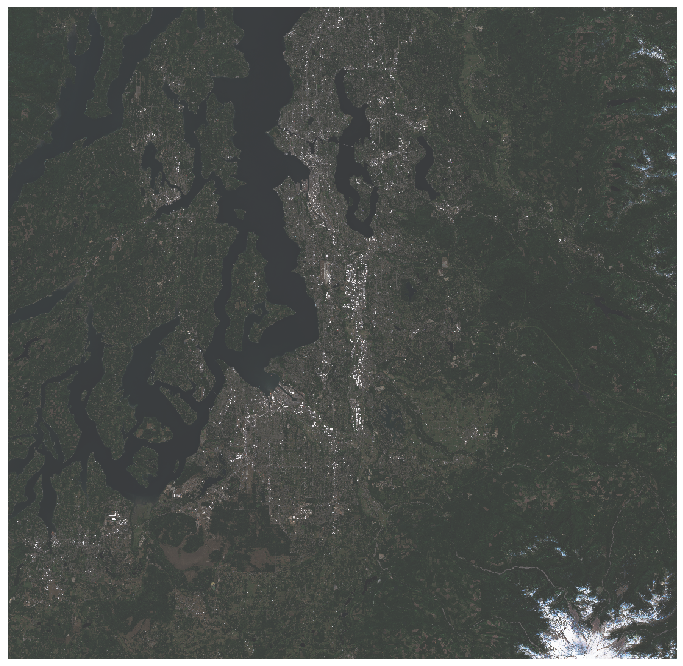

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_axis_off()
image.plot.imshow(ax=ax);

### Monthly Composite

Now suppose we don't want to combine images from different parts of the year (for example, we might not want to combine images from January that often include snow with images from July). Again using standard xarray syntax, we can create set of per-month composites by grouping by month and then taking the median.

In [12]:
monthly = data.groupby("time.month").median().compute()

Let's convert each of those arrays to a true-color image and plot the results as a grid.

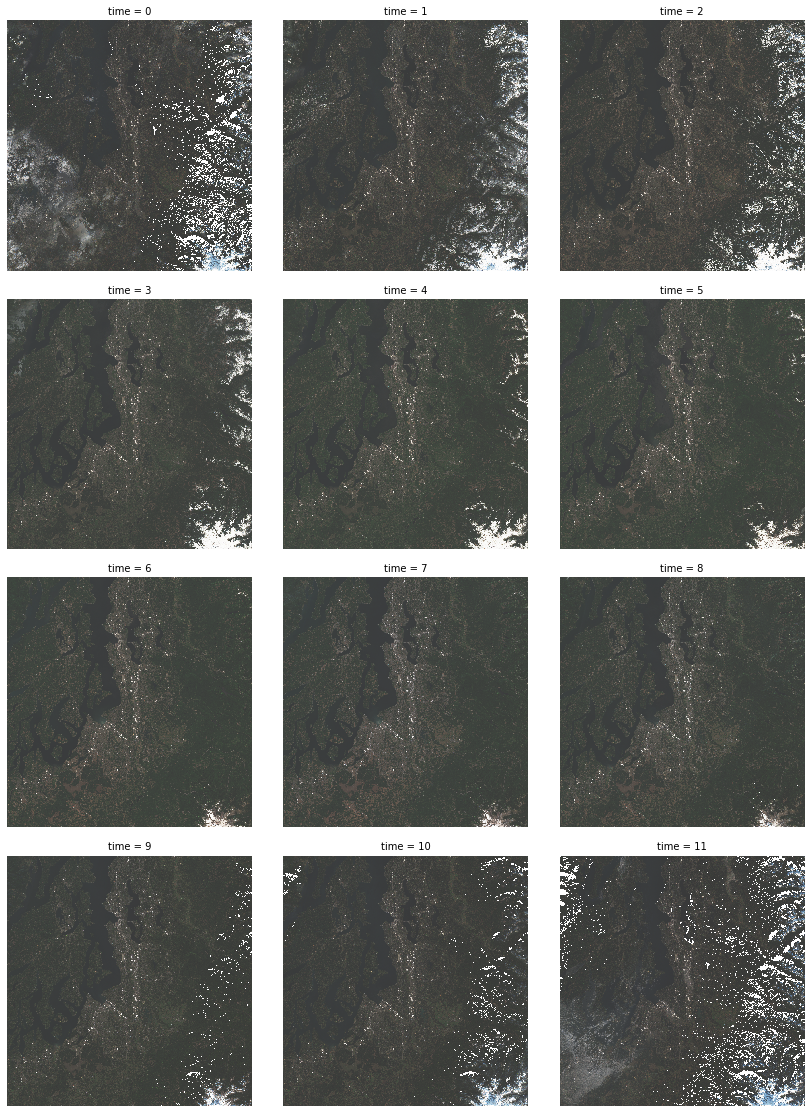

In [13]:
images = [
    ms.true_color(*x) for x in monthly
]
images = xr.concat(images, dim="time")

g = images.plot.imshow(x="x", y="y", rgb="band", col="time", col_wrap=3, figsize=(12, 16))
for ax in g.axes.flat:
    ax.set_axis_off()

### Learn More

To learn more about querying the Planetary Computer's STAC endpoint, see [../quickstarts/reading-stac.ipynb](Reading data from the STAC API). For more about Dask, see [../quickstarts/scaling-with-dask.ipynb](Scale with Dask).